My fellow MLBoosters, thanks for watching and visiting. This is the notebook used for episode Uncertainty Quantification (5): Avoid these Missteps in Validating Your Conformal Claims! If you found the episode and this notebook useful, I ask that please consider giving **a star to the GitHub repository [here](https://github.com/mtorabirad/MLBoost)**.

# Table of Contents

- [Train and Conformalize Point Predictor](#PP)
- [MLBoost Conformalizer Class Used in the Last and Current Episodes](#MLBoost)
- [Validating Conformal Libraries](#Libs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MLBoostVideos/UncertaintyQuantification/Episode15/Code

/content/drive/MyDrive/MLBoostVideos/UncertaintyQuantification/Episode15/Code


In [ ]:
#!git clone https://github.com/awslabs/fortuna.git
!pip install poetry --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 47.5 MB/s eta 0:00:00


In [ ]:
%cd fortuna

/content/drive/MyDrive/MLBoostVideos/UncertaintyQuantification/Episode15/Code/fortuna


In [ ]:
!poetry install --quiet

In [ ]:
from fortuna.conformal.regression.onedim_uncertainty import OneDimensionalUncertaintyConformalRegressor


In [ ]:
#!pip install mapie puncc aws-fortuna --quiet
!pip install mapie puncc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 11.1 MB/s eta 0:00:00


In [ ]:
from mapie.regression import MapieRegressor
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm



<a name="MLBoost"></a>
## MLBoost Conformalizer Class Used in the Last and Current Episodes

---



In [ ]:
class MLBoostConformalizer():
  def __init__(self,
               pre_trained_model,
               non_conformity_func,
               delta,
               calib_data):

    # Initialize the conformalizer with required parameters
    self.point_predictor = pre_trained_model
    self.non_conformity_func = non_conformity_func
    self.n_calib = calib_data['X'].shape[0]
    self.delta = delta
    self._calibrate(calib_data['X'], calib_data['y'])


  def _calculate_quantile(self, scores_calib, delta):
    # Calculate the quantile value based on delta and non-conformity scores
    self.which_quantile = np.ceil((self.delta)*(self.n_calib + 1))/self.n_calib
    return np.quantile(scores_calib, self.which_quantile, method='lower')


  def _calibrate(self, X_calib, y_calib):
    # Calibrate the conformalizer to calculate q_hat
    y_calib_pred = self.point_predictor.predict(X_calib)
    scores_calib = self.non_conformity_func(y_calib_pred, y_calib)
    self.q_hat = self._calculate_quantile(scores_calib, self.delta)


  def predict(self, X):
    # Returns the predicted interval
    y_pred = self.point_predictor.predict(X)
    y_lower, y_upper = y_pred - self.q_hat, y_pred + self.q_hat
    return y_lower, y_pred, y_upper

def non_conformity_func(y, y_hat):
  return np.abs(y - y_hat)


In [ ]:
def running_average(arr):
  cumsum = np.cumsum(arr)
  indices = np.arange(1, len(arr) + 1)
  running_avg = cumsum / indices
  return running_avg

<a name="PP"></a>
## Train and Conformalize Point Predictor

In [ ]:
# Load the Boston Housing Data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
#delta = 0.8
#n_calib = int(1/(1 - delta))

exact_to_upper_ratio = 0.5
n_calib = 6
an_integer = n_calib - 1# an integer less than n_calib + exact_to_upper_ration
#delta = (an_integer + 1 - exact_to_upper_ratio)/(n_calib + 1)
delta = 0.8

n_test = 200
n_train = len(target) - n_calib - n_test

num_splits = 10000
calib_data = {}
test_data = {}

In [ ]:
n_calib, delta

(6, 0.8)

In [ ]:
# Split Dataset into train, calib, and validation sets
X_train, X_cal_test, y_train, y_cal_test = \
    train_test_split(data, target, train_size=n_train, random_state=1)

X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test, random_state=1)

In [ ]:
# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make Point Predictions
y_point_pred = model.predict(X_test)

In [ ]:
lower_bound, upper_bound, exact_coverage = delta, (delta + 1/(n_calib+1)), (np.ceil((n_calib+1)*delta))/(n_calib+1)

In [ ]:
calib_data = {'X': X_cal, 'y': y_cal}
conformalized_model = MLBoostConformalizer(model, non_conformity_func, delta, calib_data)
y_lower, y_pred, y_upper = conformalized_model.predict(X_test)
fraction_within_bounds = np.mean((y_test >= y_lower) & (y_test <= y_upper))
fraction_within_bounds

0.925

In [ ]:
empirical_coverages_for_all_splits_MLBoost = []


with tqdm.tqdm(total=num_splits, desc='running trials') as pbar:

  for a_trial in range(1, num_splits):
    X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test, random_state=a_trial)

    calib_data['X'], calib_data['y'] = X_cal, y_cal
    test_data['X'], test_data['y']= X_test, y_test

    conformalized_model = MLBoostConformalizer(model, non_conformity_func, delta, calib_data)
    y_pred_lower, y_pred, y_pred_upper = conformalized_model.predict(test_data['X'])
    fraction_within_bounds_MLBoost = np.mean((test_data['y'] >= y_pred_lower) & (test_data['y'] <= y_pred_upper))
    empirical_coverages_for_all_splits_MLBoost.append(fraction_within_bounds_MLBoost)
    pbar.update()



running trials: 100%|█████████▉| 9999/10000 [00:19<00:00, 506.56it/s]


<Figure size 2400x1800 with 0 Axes>

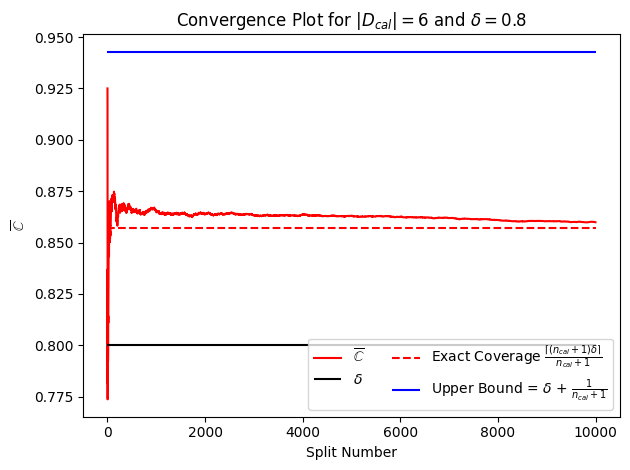

In [ ]:
running_averages_MLBoost = running_average(empirical_coverages_for_all_splits_MLBoost)
plt.figure(figsize=(8, 6), dpi=300)

fig, ax = plt.subplots()

ax.plot(running_averages_MLBoost, alpha=1, label=r'$\overline{\mathbb{C}}$', c='r')


plt.hlines(lower_bound, 0, num_splits, label=r'$\delta$', color='k')
plt.hlines(exact_coverage, 0, num_splits, label=r'Exact Coverage $\frac{\lceil (n_{cal}+1)\delta \rceil}{n_{cal}+1}$', color='r', ls='--')
plt.hlines(upper_bound, 0, num_splits, label=r'Upper Bound = $\delta$ + $\frac{1}{n_{cal}+1}$', color='b')
# inset axes....
# delta = 0.9
'''
x1, x2, y1, y2 = 9000, 10000, 0.895, 0.905
axins = ax.inset_axes(
    [0.3, 0.3, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
'''

# delta = 0.8
'''
x1, x2, y1, y2 = 9000, 10000, 0.795, 0.85
axins = ax.inset_axes(
    [0.3, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])



axins.plot(running_averages_MLBoost, alpha=1, label=r'$\overline{\mathbb{C}}', c='r')
axins.hlines(lower_bound, 0, num_splits, color='k')
axins.hlines(upper_bound, 0, num_splits, color='k')
axins.hlines(exact_coverage, 0, num_splits, color='r', ls='--')




ax.indicate_inset_zoom(axins, edgecolor="black")
#axins.set_xticks(np.linspace(x1, x2, 4))  # Specify the x tick locations
#axins.set_yticks(np.linspace(y1, y2, 4))  # Specify the y tick locations
import matplotlib.ticker as ticker

# Automatically set ticks and tick labels for the inset plot
axins.xaxis.set_major_locator(ticker.AutoLocator())
axins.yaxis.set_major_locator(ticker.AutoLocator())
axins.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axins.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axins.xaxis.set_major_formatter(ticker.ScalarFormatter())
axins.yaxis.set_major_formatter(ticker.ScalarFormatter())
'''

plt.xlabel('Split Number')
plt.ylabel('$\overline{\mathbb{C}}$')
plt.title('Convergence Plot for $|D_{cal}| = $' + str(n_calib) + ' and $\delta = $' + str(delta))
plt.legend(loc='lower right', ncol=2)
plt.tight_layout()
file_name = 'Convergence Plot for $|D_{cal}| = $' + str(n_calib) + 'exact'
plt.savefig(file_name, dpi=300)



<a name="Libs"></a>

### Validating Conformal Libraries


In [ ]:
def get_coverage_for_PUNCC(model, X_cal, X_test, y_cal, y_test, delta):
  split_cp = SplitCP(model, train=False)
  split_cp.fit(X_calib=X_cal, y_calib=y_cal)
  y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=1-delta)
  fraction_within_bounds = np.mean((y_test >= y_pred_lower) & (y_test <= y_pred_upper))
  return fraction_within_bounds


In [ ]:
def get_coverage_for_MAPIE(model, X_cal, X_test, y_cal, y_test, delta):
  mapie_reg = MapieRegressor(estimator=model, cv="prefit")
  mapie_reg.fit(X_cal, y_cal)
  y_pred, y_pis = mapie_reg.predict(X_test, alpha=1-delta)
  fraction_within_bounds = np.mean((y_test >= y_pis[:, 0, 0]) & (y_test <= y_pis[:, 1, 0]))
  return fraction_within_bounds


In [ ]:
def get_coverage_for_FORTUNA(model, X_cal, X_test, y_cal, y_test, delta):
  conformal_intervals = OneDimensionalUncertaintyConformalRegressor().conformal_interval(
      val_preds=model.predict(X_cal).reshape(-1, 1),
      val_uncertainties=np.ones(X_cal.shape[0]).reshape(-1, 1),
      test_preds=model.predict(X_test).reshape(-1, 1),
      test_uncertainties=np.ones(X_test.shape[0]).reshape(-1, 1),
      val_targets=y_cal.reshape(-1, 1),
      error=1-delta
      )

  fraction_within_bounds = np.mean((y_test >= conformal_intervals[:,0]) & (y_test <= conformal_intervals[:,1]))
  fraction_within_bounds = fraction_within_bounds.tolist()
  return fraction_within_bounds

In [ ]:
get_coverage_for_FORTUNA(model, X_cal, X_test, y_cal, y_test, delta)

0.8149999976158142

In [ ]:
empirical_coverages_for_all_splits_MAPIE = []
empirical_coverages_for_all_splits_puncc = []
empirical_coverages_for_all_splits_Fortuna = []

calib_data = {}
valid_data = {}
#num_splits = 100
with tqdm.tqdm(total=num_splits, desc='running trials') as pbar:

  for a_trial in range(num_splits):


    ### PUNCC
    X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test)
    empirical_coverages_for_all_splits_puncc.append(get_coverage_for_PUNCC(model, X_cal, X_test, y_cal, y_test, delta))


    ### MAPIE
    X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test)
    try:
      empirical_coverages_for_all_splits_MAPIE.append(get_coverage_for_MAPIE(model, X_cal, X_test, y_cal, y_test, delta))
    except:
      empirical_coverages_for_all_splits_MAPIE.append(np.nan)

    ### Fortuna
    X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test)
    empirical_coverages_for_all_splits_Fortuna.append(get_coverage_for_FORTUNA(model, X_cal, X_test, y_cal, y_test, delta))
    pbar.update(1)

running trials: 100%|██████████| 10000/10000 [16:55<00:00,  9.85it/s]


In [ ]:
running_averages_MAPIE = running_average(empirical_coverages_for_all_splits_MAPIE)
running_averages_puncc = running_average(empirical_coverages_for_all_splits_puncc)
running_averages_Fortuna = running_average(empirical_coverages_for_all_splits_Fortuna)

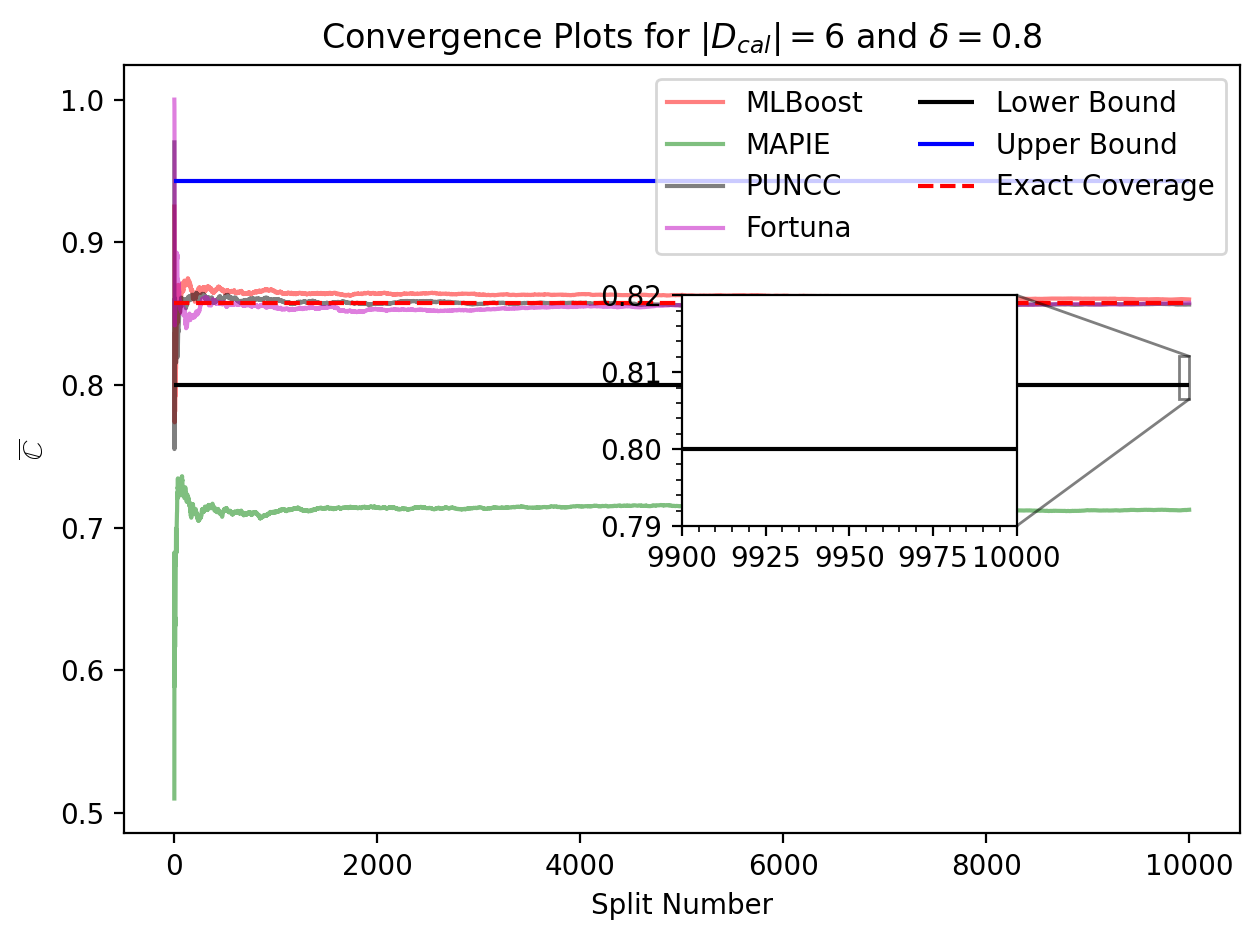

In [ ]:
#plt.figure(figsize=(8, 6), dpi=300)
fig, ax = plt.subplots(dpi=200)
plt.plot(running_averages_MLBoost, alpha=0.5, label='MLBoost', color='r')
plt.plot(running_averages_MAPIE, alpha=0.5, label='MAPIE', color='g')
plt.plot(running_averages_puncc, alpha=0.5, label='PUNCC', color='k')
plt.plot(running_averages_Fortuna, alpha=0.5, label='Fortuna', color='m')


#plt.hlines(lower_bound, 0, num_splits, label=r'Lower Bound = 1 - $\alpha$', color='k')
#plt.hlines(upper_bound, 0, num_splits, label=r'Upper Bound = 1 - $\alpha$ + $\frac{1}{n_{cal}+1}$', color='b')
#plt.hlines(exact_coverage, 0, num_splits, label=r'Exact Coverage $\frac{\lceil (n_{cal}+1)\delta \rceil}{n_{cal}+1}$', color='r')

plt.hlines(lower_bound, 0, num_splits, color='k', label='Lower Bound')
plt.hlines(upper_bound, 0, num_splits, color='b', label='Upper Bound')
plt.hlines(exact_coverage, 0, num_splits, color='r', ls='--', label='Exact Coverage')

plt.xlabel('Split Number')
plt.ylabel('$\overline{\mathbb{C}}$')
plt.title('Convergence Plots for $|D_{cal}| = $' + str(n_calib) + ' and $\delta = $' + str(delta))


x1, x2, y1, y2 = 9900, 10000, 0.79, 0.82
axins = ax.inset_axes(
    [0.5, 0.4, 0.3, 0.3],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])



#axins.plot(running_averages, alpha=1, label=r'$\overline{\mathbb{C}}', c='r')

axins.plot(running_averages_MAPIE, alpha=0.5, label='MAPIE', color='g')
axins.plot(running_averages_MLBoost, alpha=0.5, label='MLBoost', color='r')
axins.plot(running_averages_puncc, alpha=0.5, label='PUNCC', color='k')
axins.plot(running_averages_Fortuna, alpha=0.5, label='Fortuna', color='m')

axins.hlines(lower_bound, 0, num_splits, color='k')
axins.hlines(upper_bound, 0, num_splits, color='b')
axins.hlines(exact_coverage, 0, num_splits, color='r', ls='--')




ax.indicate_inset_zoom(axins, edgecolor="black")
import matplotlib.ticker as ticker

# Automatically set ticks and tick labels for the inset plot
axins.xaxis.set_major_locator(ticker.AutoLocator())
axins.yaxis.set_major_locator(ticker.AutoLocator())
axins.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axins.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axins.xaxis.set_major_formatter(ticker.ScalarFormatter())
axins.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.legend(loc="upper right", ncol=2)
#plt.ylim(0.7, 1)
plt.tight_layout()
plt.savefig('DifferentLibraries' + str(n_calib), dpi=300)


In [ ]:
'''
import concurrent.futures

def process_data(model, X_cal, X_test, y_cal, y_test, delta, function):
    if function == 'PUNCC':
        return 'PUNCC', get_coverage_for_PUNCC(model, X_cal, X_test, y_cal, y_test, delta)
    elif function == 'MAPIE':
        return 'MAPIE', get_coverage_for_MAPIE(model, X_cal, X_test, y_cal, y_test, delta)
    elif function == 'FORTUNA':
        return 'FORTUNA', get_coverage_for_FORTUNA(model, X_cal, X_test, y_cal, y_test, delta)

def run_trial(model, X_cal_test, y_cal_test, n_test, delta, num_splits):
    empirical_coverages = {'PUNCC': [], 'MAPIE': [], 'FORTUNA': []}
    with tqdm.tqdm(total=num_splits, desc='running trials') as pbar:

      for a_trial in range(num_splits):
          with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
              futures = []
              for function in ['PUNCC', 'MAPIE', 'FORTUNA']:
                  X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=n_test)
                  futures.append(executor.submit(process_data, model, X_cal, X_test, y_cal, y_test, delta, function))
              for future in concurrent.futures.as_completed(futures):
                  function_name, result = future.result()
                  empirical_coverages[function_name].append(result)
          pbar.update(1)

    return empirical_coverages

# Example usage
# Replace 'model' with your actual model object
empirical_coverages_for_all_splits = run_trial(model, X_cal_test, y_cal_test, n_test, delta, num_splits)
'''

"\nimport concurrent.futures\n\ndef process_data(model, X_cal, X_test, y_cal, y_test, delta, function):\n    if function == 'PUNCC':\n        return 'PUNCC', get_coverage_for_PUNCC(model, X_cal, X_test, y_cal, y_test, delta)\n    elif function == 'MAPIE':\n        return 'MAPIE', get_coverage_for_MAPIE(model, X_cal, X_test, y_cal, y_test, delta)\n    elif function == 'FORTUNA':\n        return 'FORTUNA', get_coverage_for_FORTUNA(model, X_cal, X_test, y_cal, y_test, delta)\n\ndef run_trial(model, X_cal_test, y_cal_test, n_test, delta, num_splits):\n    empirical_coverages = {'PUNCC': [], 'MAPIE': [], 'FORTUNA': []}\n    with tqdm.tqdm(total=num_splits, desc='running trials') as pbar:\n\n      for a_trial in range(num_splits):\n          with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:\n              futures = []\n              for function in ['PUNCC', 'MAPIE', 'FORTUNA']:\n                  X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, t